In [1]:
name = '2017-03-17-numpy-finite-diff'
title = 'Some examples on numerical differentiation in Python'
tags = 'numpy'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML, Image

html = connect_notebook_to_post(name, title, tags, author)

Going through Mark's [Ocean World climate model code](https://github.com/multilingualtricker/CretinousCode), one of the improvements that we discussed this Friday was moving from nested `for`-loops to array-wide operations. Sometimes this is called *vectorisation*, even though operations are performed not only on 1D-vectors, but on N-dimensional arrays.

The most interesting part was to apply this concept to the finite differences, specifically to the horizontal diffusion, which is the mechanism of transporting heat in the ocean and the atmosphere in Mark's model (there is no advection).

Changes that we made can be viewed on GitHub:
* [First introduction of vectorised finite differences (using `numpy.roll()` function)](https://github.com/multilingualtricker/CretinousCode/commit/d89e35cf77ba699b13146c92bb3d9b5a487e3094)
* [Cleaner version with a diffusion subroutine](https://github.com/multilingualtricker/CretinousCode/commit/ab4011f6b5c93b22bbc49f6ccca8486d39a10557)

In this notebook you can go through simpler examples of diffusion problem and see for yourself why NumPy is great.

**Examples in this notebook are taken from the book ["High Performance Python"](http://shop.oreilly.com/product/0636920028963.do).**

## Pure Python

* Python doesn’t *natively* support vectorization. 
* There are two reasons for this:
    - Python lists store pointers to the actual data,
    - Python bytecode is not optimized for vectorization, so for loops cannot predict when using vectorization would be beneficial.


In [3]:
# import time module to get execution time
import time
# plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Diffusion problem

Let's use a square grid.

In [4]:
grid_shape = (1024, 1024)

In [5]:
def evolve(grid, dt, out, D=1.0):
    xmax, ymax = grid_shape
    for i in range(xmax):
        for j in range(ymax):
            grid_xx = grid[(i+1) % xmax][j] + grid[(i-1) % xmax][j] - 2.0 * grid[i][j]
            grid_yy = grid[i][(j+1) % ymax] + grid[i][(j-1) % ymax] - 2.0 * grid[i][j]
            out[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt

Note that `evolve()` function does not return anything, because lists are mutable objects and their elements can be modified in place.

In [6]:
def run_experiment(num_iterations):
    xmax, ymax = grid_shape
    
    # Allocate lists of lists to use as 2d arrays
    next_grid = [[0.0,] * ymax for x in range(xmax)]
    grid = [[0.0,] * ymax for x in range(xmax)]
    
    # Set up initial conditions
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    for i in range(block_low, block_high):
        for j in range(block_low, block_high):
            grid[i][j] = 0.005
    
    # Start of integration
    start = time.time()
    for i in range(num_iterations):
        evolve(grid, 0.1, next_grid)
        grid, next_grid = next_grid, grid
    return time.time() - start

In [7]:
exec_time = run_experiment(10)
print('Execution time of 10 iterations: {:.2f} s'.format(exec_time))

Execution time of 10 iterations: 9.47 s


Pretty slow!

## NumPy

* Luckily, numpy has all of the features we need - it stores data in **contiguous chunks of memory**
* It supports vectorized operations on its data
* As a result, any arithmetic we do on numpy arrays happens in chunks without us having to explicitly loop over each element

## Example to calculate vector norm

Fake data:

In [8]:
vector = list(range(1000000))

#### pure python

In [9]:
def norm_square_list(vector):
    norm = 0
    for v in vector:
        norm += v * v
    return norm

In [10]:
%timeit norm_square_list(vector)

10 loops, best of 3: 71.8 ms per loop


In [11]:
def norm_square_list_comprehension(vector):
    return sum([v*v for v in vector])

In [12]:
%timeit norm_square_list_comprehension(vector)

10 loops, best of 3: 80.7 ms per loop


In [13]:
def norm_squared_generator_comprehension(vector):
    return sum(v*v for v in vector)

In [14]:
%timeit norm_squared_generator_comprehension(vector)

10 loops, best of 3: 81.8 ms per loop


#### the same, but with numpy

In [15]:
import numpy as np

In [16]:
vector = np.arange(1000000)

In [17]:
def norm_square_numpy(vector):
    return np.sum(vector * vector)

In [18]:
%timeit norm_square_numpy(vector)

100 loops, best of 3: 3.06 ms per loop


In [19]:
def norm_square_numpy_dot(vector):
    return np.dot(vector, vector) 

In [20]:
%timeit norm_square_numpy_dot(vector)

1000 loops, best of 3: 935 µs per loop


## Applying numpy to finite differences

Generic differences

* `numpy.gradient()`

* `numpy.diff()`

In [21]:
a = np.arange(10, 20, 2)
a

array([10, 12, 14, 16, 18])

In [22]:
np.diff(a)

array([2, 2, 2, 2])

In [23]:
a[1:] - a[:-1]

array([2, 2, 2, 2])

### Diffusion Problem

To compare to the pure Python we use the same grid and same initial conditions.

In [24]:
grid_shape = (1024, 1024)

In [25]:
def laplacian(grid):
    return (np.roll(grid, +1, 0) + np.roll(grid, -1, 0) +
            np.roll(grid, +1, 1) + np.roll(grid, -1, 1) - 4 * grid)

In [26]:
def evolve(grid, dt, D=1):
    return grid + dt * D * laplacian(grid)

In [27]:
def run_experiment_numpy(num_iterations):
    # Allocate 2d array
    grid = np.zeros(grid_shape)
    
    # Initial conditions
    block_low = int(grid_shape[0] * .4)
    block_high = int(grid_shape[0] * .5)
    grid[block_low:block_high, block_low:block_high] = 0.005
    
    # Save the initial conditions to use in the plotting section
    grid0 = grid.copy()
    
    # Integrate in time
    start = time.time()
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
    return grid0, grid, time.time() - start

In [28]:
n = 1000
g0, g, exec_time = run_experiment_numpy(n)

In [29]:
print('Execution time of 10 iterations: {:.2f} s'.format(exec_time / (n / 10)))

Execution time of 10 iterations: 0.52 s


We can see that even for this simple example using `numpy` improves performance by at least 1-2 orders of magnitude. The code also is cleaner and shorter than in native-Python implementation.

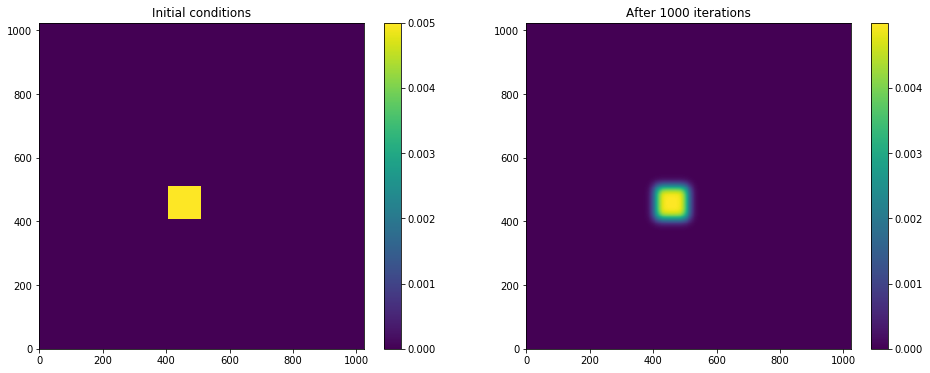

In [30]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6))

h = ax0.pcolormesh(g0)
fig.colorbar(h, ax=ax0)
ax0.set_title('Initial conditions')

h = ax1.pcolormesh(g)
fig.colorbar(h, ax=ax1)
ax1.set_title('After {n} iterations'.format(n=n))

## References
M. Gorelick, I. Ozsvald, 2014. *High Performance Python*. O'Reilly Media.

In [31]:
HTML(html)